In [1]:
import pandas
from sagemaker import get_execution_role


def import_csv_file_from_bucket(fileName):
    role = get_execution_role()
    bucket = 'morkalork'
    data_location = 's3://{}/data/{}'.format(bucket, fileName)
    return pandas.read_csv(data_location)

data = import_csv_file_from_bucket('AirPassengers.csv')
data.head()

,Unnamed: 0,time,value
0,1,1949.000000,112
1,2,1949.083333,118
2,3,1949.166667,132
3,4,1949.250000,129
4,5,1949.333333,121


In [2]:
import matplotlib.pyplot as plotiker_von_klimp

data.set_index('time').plot()
plotiker_von_klimp.show()

<Figure size 640x480 with 1 Axes>

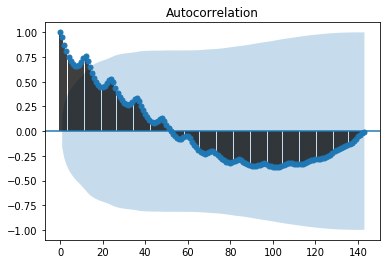

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.set_index('time')['value'])
plotiker_von_klimp.show()

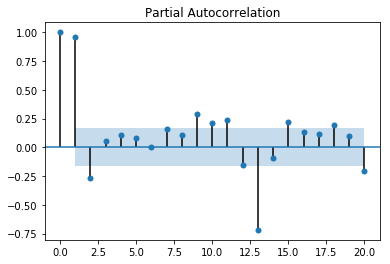

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.set_index('time')['value'], lags=20)
plotiker_von_klimp.show()

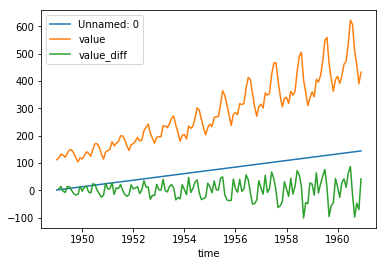

In [5]:
data.set_index('time', inplace=True)
data['value_diff'] = data['value'].diff()
data.plot()
plotiker_von_klimp.show()

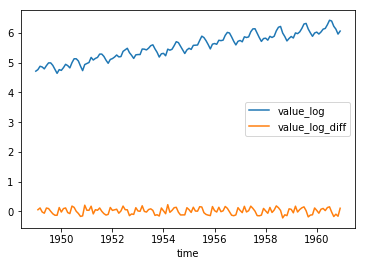

In [6]:
import math

data = import_csv_file_from_bucket('AirPassengers.csv') #Refresh

data['value_log'] = data['value'].apply(lambda x: math.log(x))
data.set_index('time', inplace=True)
data['value_log_diff'] = data['value_log'].diff()
data[['value_log', 'value_log_diff']].plot()
plotiker_von_klimp.show()

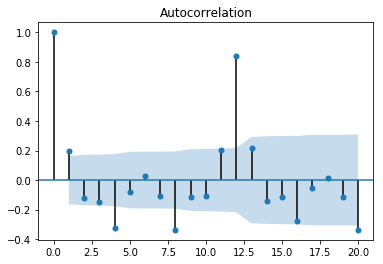

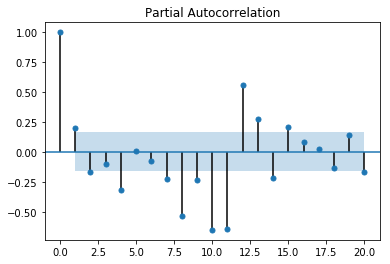

In [7]:
plot_acf(data[data.value_log_diff.notnull()]['value_log_diff'], lags=20)
plotiker_von_klimp.show()
plot_pacf(data[data.value_log_diff.notnull()]['value_log_diff'], lags=20)
plotiker_von_klimp.show()

In [8]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy

data = import_csv_file_from_bucket('AirPassengers.csv') #Refresh
data['value_log'] = data['value'].apply(lambda x: math.log(x))
data['value_log_diff'] = data['value_log'].diff()

data_not_null = data[data.value_log_diff.notnull()]
split_index = 2 * len(data) / 3
train = data_not_null.loc[:split_index]
test = data_not_null.loc[split_index + 1:]

model = AR(train['value_log_diff'].values)
model_fit = model.fit(2)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 2
Coefficients: [ 0.00920726  0.1868782  -0.19667703]


In [9]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
predictions_df = pandas.DataFrame(predictions, columns=['forecast_log_diff'], index=test.index)
test = test.join(predictions_df)
test.loc[:, 'forecast'] = test.loc[:, 'forecast_log_diff'].cumsum() + data.loc[split_index - 1, 'value_log']
test.loc[:, 'forecast'] = test.loc[:, 'forecast'].apply(lambda x: numpy.exp(x))
mse = mean_squared_error(test['value'].values, test['forecast'].values)
print('RMSE: %f' % math.sqrt(mse))

RMSE: 76.456459


In [10]:
model_fit_df = pandas.DataFrame([numpy.nan, numpy.nan] + model_fit.fittedvalues.tolist(), columns=['model_fit_log_diff'], index=train.index)
train = train.join(model_fit_df)
train.loc[:, 'model_fit'] = train.loc[:, 'model_fit_log_diff'].cumsum() + data.loc[2, 'value_log']
train.loc[:, 'model_fit'] = train.loc[:, 'model_fit'].apply(lambda x: numpy.exp(x))
train.head()

,Unnamed: 0,time,value,value_log,value_log_diff,model_fit_log_diff,model_fit
1,2,1949.083333,118,4.770685,0.052186,NaN,NaN
2,3,1949.166667,132,4.882802,0.112117,NaN,NaN
3,4,1949.250000,129,4.859812,-0.022990,0.019896,134.652545
4,5,1949.333333,121,4.795791,-0.064022,-0.017140,132.364283
5,6,1949.416667,135,4.905275,0.109484,0.001764,132.598043


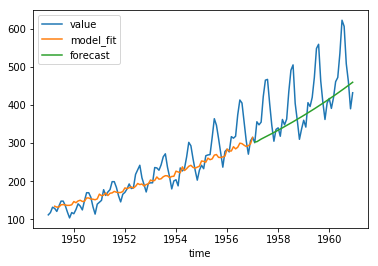

In [11]:
data = data.join(test['forecast'])
data = data.join(train['model_fit'])
data.set_index('time')[['value', 'model_fit', 'forecast']].plot()
plotiker_von_klimp.show()